In [32]:
import pandas as pd
from pathlib import Path
import arrow
from collections import Counter
import json
import matplotlib.pyplot as plt
import nltk
from tqdm import tqdm
nltk.download('punkt')

## Intoduction
The following notebook provides some insights into the `mimic-III` database. <br> 
Firstly, we are going to look how we can determine which patients have developed sepsis and are interesting for our study. Then, we will take a look at few tables that contains sepsis-related features. Lastly, we will take a look at the table that contains the clinical notes and have a few insights about it. <br>
This notebook is used only for exploration purposes. Please refer to the `mimic_events_icu_generation.py` and `mimic_preprocessed_data_generation.py` to generate the data for the experiments.

In [2]:
DATA_FOLDER = Path.home() / "uni" / "data" 
mimic_path = DATA_FOLDER / "mimic-iii-clinical-database-1.4"

documents = [fp for fp in (mimic_path).rglob("*.csv") if fp.is_file() and fp.stem[0] != '.']
len(documents)

26

## Names of mimic tables

In [2]:
for ind, doc in enumerate(documents):
    print(ind, str(doc).rsplit("/")[-1])

### Diagnosis table <br>
From the following table the patient/ hospital admission ids can be taken based on the `ICD9_CODE`.  


In [1]:
diagnosis_path = documents[16]
diagnosis_table = pd.read_csv(diagnosis_path)
diagnosis_table.head()

In order to determine which `ICD9_CODE`s are of interest, one needs to go through the `D_ICD_DIAGNOSES` and extract the ICD9 codes based on the `LONG_TITLE` in the table. <br>
Below, one can see how the table looks like and a short example with the `IC9_CODE` and its corresponding description

In [3]:
diagnosis_names = pd.read_csv(documents[21])
diagnosis_names.head()

In [4]:
for index, row in diagnosis_names.iterrows():
    if 'sepsis' in row['LONG_TITLE']:
        print(row["ICD9_CODE"], row["SHORT_TITLE"])

For this project 23 sepsis codes were used. The codes vary depending on which bacteria is related to the patient's sepsis, as well as when sepsis has occured or whether it is severe or not. <br>
SIRS has the following `ICD9_CODE`: 99590. It is, however, not part of the list, as no patients in our set had it. 

In [7]:
sepsis_icd_codes = [
    "0380","03810", "03811", "03812", "03819","0382","0383","03840",
    "03841","03842","03843","03844","03849","0388","0389","67020","67022",
    "67024","67030","67032","67034","99591","99592" ]

Now it is important to determine which patients have been admitted with sepsis. Those patients we want to remove from our experiments, because the forecasting model cannot learn anything from them. The `ADMISSIONS` table does not have any ICD9 codes, so those patients need to be extracted based on string matches.

In [5]:
# admission = pd.read_csv(documents[8])
# admission.head()

In [9]:
#(id, hadm_id, admittion_time, discharge_time, diagnosis)
patient_admission_info = [
    (x,admission["HADM_ID"][ind],admission["ADMITTIME"][ind],
     admission["DISCHTIME"][ind],admission["DIAGNOSIS"][ind]) 
    for ind, x in enumerate(admission["SUBJECT_ID"])
]

septic_diagnosis = []
for column_value in patient_admission_info:
    # column_value[4] corresponds to the diagnosis entries
    if type(column_value[4]) != float:
        if "sepsis" in column_value[4].lower():
            septic_diagnosis.append(column_value)
        elif "septicemia" in column_value[4].lower():
            septic_diagnosis.append(column_value)

#get ids of patient who has sepsis on admission
admission_patients_sepsis = [str(x[0]) for x in septic_diagnosis]
print("No. of patients with sepsis diagnosis upon admission:",len(admission_patients_sepsis))

No. of patients with sepsis diagnosis upon admission: 1785


In [10]:
#get a list with the patient ids and their diagnosis 
patient_codes = [(diagnosis_table["SUBJECT_ID"][ind],x) for ind, x in enumerate(diagnosis_table["ICD9_CODE"])]

#keep only the patients with sepsis codes         
final_patients = [str(patient[0]) for patient in patient_codes if type(patient[1]) != float for el in sepsis_icd_codes if el in patient[1]]
final_patients = list(set(final_patients) - set(admission_patients_sepsis))

print("Number of patients who develpoed sepsis: ",len(final_patients))    

Number of patients who develpoed sepsis:  4272


In [11]:
# get the hamd_id for later visualizations
patient_codes_hadm = [(diagnosis_table["HADM_ID"][ind],x) for ind, x in enumerate(diagnosis_table["ICD9_CODE"])]
final_patients_ham = [patient[0] for patient in patient_codes_hadm if type(patient[1]) != float for el in sepsis_icd_codes if el in patient[1]]
final_patients_hamd_id = list(set(final_patients_ham))

Now we also want to check that minor patients are not included in our final patient's set

In [6]:
patients = pd.read_csv(documents[20])
#(subject_id, gender, DOB)
patient_info = [(x,patients["GENDER"][ind],patients["DOB"][ind]) for ind, x in enumerate(patients["SUBJECT_ID"])]
print(patient_info[0])

In [13]:
younger_than_18 = []
newborn = []
for patient in patient_admission_info:
    for triplet in patient_info:
        if patient[0] == triplet[0]:
            dob = arrow.get(triplet[2].split(" ")[0])
            admin = arrow.get(patient[2].split(" ")[0])
            delta = str(admin - dob).split(" ")[0]
            if delta != '0:00:00':
                age = int(delta)/365
                if age < 18:
                    younger_than_18.append(triplet)
            else: 
                newborn.append(triplet)

In [14]:
young_ids = [x[0] for x in younger_than_18]
newborn_ids = [x[0] for x in newborn]
underage = young_ids + newborn_ids

#check if any minors are present in the final set of patients
set(final_patients).intersection(set(underage))

set()

### Exploring Sepsis-related features
Now we can look at few other tables that are of interest to us. Those include `MICROBIOLOGYEVENTS`, `PRESCRIPTION`, `PROCEDUREEVENTS` and `NOTEEVENTS`

#### Blood Culture

In [7]:
microbiology = pd.read_csv(documents[5])
microbiology.head()

From this table we are only interest in `BLOOD CULTURE` and the time they were taken. We can get the desired rows based on the `SPEC_ITEMID`. The ID for blood culture is 70012.0 

In [8]:
blood_culture = microbiology.query("SPEC_ITEMID ==70012.0")
blood_culture.loc[:, ["SUBJECT_ID","HADM_ID","CHARTDATE","CHARTTIME","SPEC_TYPE_DESC"]]

#### Antibiotics
Now we can look at the `PRESCRIPTION` table. From this table we can collect the times that antibiotics have been admittived intravenously. <br>
The antibiotics of interest are: <br>
- ceftriaxone (Rocephin) 
- piperacillin-tazobactam 
- cefepime (Maxipime) 
- ceftazidime (Fortaz) 
- vancomycin (Firvanq) 
- ciprofloxacin (Cipro) 
- levofloxacin (Levaquin) 
- meropenem 
- imipenem/cilastatin 
- ampicillin/sulbactam 
<br>
<br>
Ideally, we want the duration IV antibiotics administration to better determine if the patient is septic or not

In [9]:
prescriptions = pd.read_csv(documents[11])
prescriptions = prescriptions.loc[:, ["ICUSTAY_ID","STARTDATE","ENDDATE","DRUG", "ROUTE"]]
prescriptions.head()

From the `PROCEDUREEVENTS` we can extract the mechanically ventilated feature, which has the `ITEMID` value of 225792

In [18]:
procedures = pd.read_csv(documents[0])

In [10]:
procedures = procedures.query('ITEMID==225792')
procedures.head()

### Clinical Notes 
Lastly, we can take a look at the clinical notes from the `NOTEEVENTS` table. This table contains free text notes which come from different departments and healthcare practitioners. Some examples include:
- Discharge summaries  
- Nursing and physician notes
- Radiology reports
- ECG reports 
- Pharmacy
- Social work <br>
<br>
Sections that often appear in these clinical notes are:
- Final Report
- History of Present Illness
- Past Medical History
- Medications
- Social History
- Brief Hospital Course
- Hospital Course
- Medications on Admission
- Discharge Medication
- Discharge Instructions

In the following section we will take a look at three things:
1. Length of texts. 
2. What were the different duration of stays for the patients that developed sepsis and 
3. How many notes were created during the stay of the patient in the hospital

In [20]:
clinical_notes = pd.read_csv(documents[13])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
clinical_notes = clinical_notes.loc[:, ["SUBJECT_ID","HADM_ID","CHARTDATE","CHARTTIME","TEXT"]]
clinical_notes.tail()

In [22]:
sepsis_patients_df = clinical_notes[clinical_notes['HADM_ID'].isin(final_patients_hamd_id)]
sepsis_patients_df.shape

(353487, 5)

The first graph gives a rough idea about the distribution of tokens to see how long the text entries are. Note that stop words have not been removed. 

In [23]:
token_counts = {}
for index, row in tqdm(sepsis_patients_df.iterrows(), total=sepsis_patients_df.shape[0]):
    # tokenize the text and get the count of tokens
    text_tokens = nltk.word_tokenize(str(row['TEXT']))
    token_count = len(text_tokens)
    # add the count to the dictionary
    if token_count in token_counts:
        token_counts[token_count] += 1
    else:
        token_counts[token_count] = 1

100%|██████████████████████████████████| 353487/353487 [14:58<00:00, 393.27it/s]


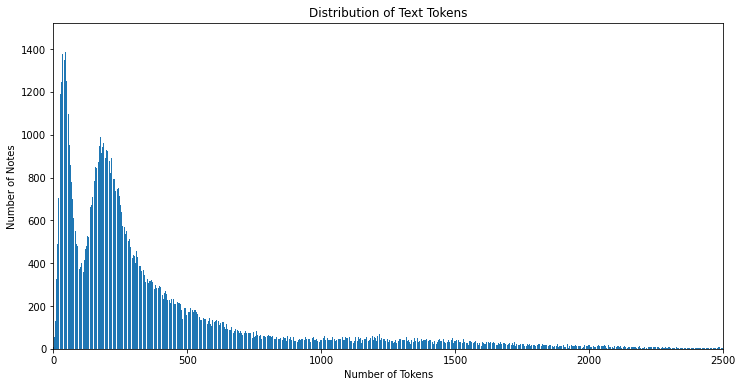

In [24]:
plt.figure(figsize=(12,6))
plt.bar(token_counts.keys(), token_counts.values())
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Notes')
plt.title('Distribution of Text Tokens')
plt.xlim(0, 2500)
plt.show()

The above graph gives a rough idea about the distribution of tokens to see how long the text entries are. Note that stop words have not been removed. <br>
From the graph it can be seen that a few letters are very long and that the majority of the letters are rather short or medium size

#### Duration of patient's stay
Now it would be interesting to see the different durations of patient's stay in the hospital. Moreover, we can see how many clinical notes did the patients receive during they stay.

/var/folders/q7/9w0rlfld07zddm0ps4d9b1dw0000gn/T/ipykernel_39313/1707145488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepsis_patients_df['CHARTDATE'] = pd.to_datetime(sepsis_patients_df['CHARTDATE'])


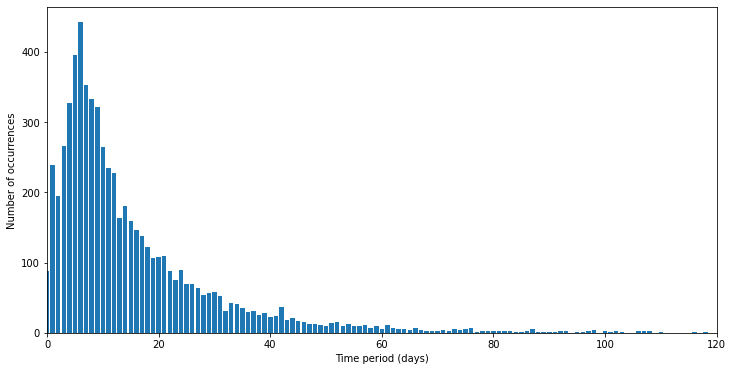

In [33]:
sepsis_patients_df['CHARTDATE'] = pd.to_datetime(sepsis_patients_df['CHARTDATE'])

df = sepsis_patients_df.sort_values(['HADM_ID', 'CHARTDATE'])

# Calculate the time period of letters in days for each HADM_ID
hadm_id_periods = {}
for hadm_id, group in df.groupby('HADM_ID'):
    first_date = group.iloc[0]['CHARTDATE']
    last_date = group.iloc[-1]['CHARTDATE']
    period = (last_date - first_date).days
    if period in hadm_id_periods:
        hadm_id_periods[period] += 1
    else:
        hadm_id_periods[period] = 1

# Plot time period of letters vs how many times those periods occured
plt.figure(figsize=(12,6))

plt.bar(hadm_id_periods.keys(), hadm_id_periods.values())
plt.xlabel('Time period (days)')
plt.ylabel('Number of occurrences')
plt.xlim(0, 120)
plt.savefig("period_of_stay")
plt.show()


The above graph shows that most patients spent under 20 days in the icu. However, there appear also to be cases where patients stays longer than 100 days. On average, a patient spents about 15 days in the icu.

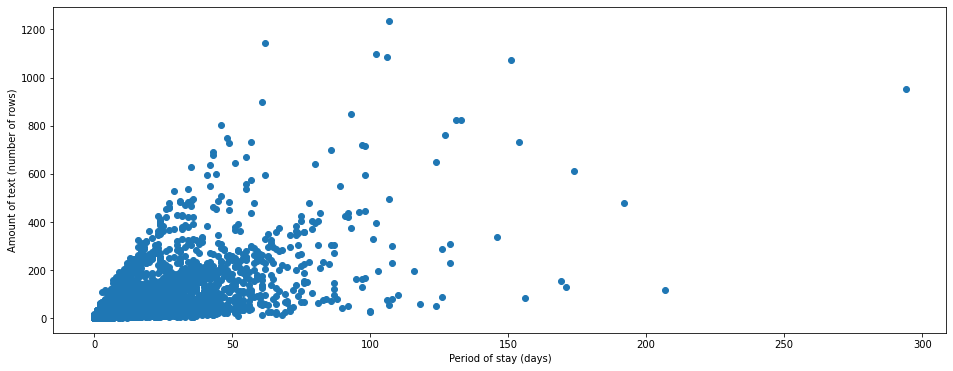

In [31]:
# Calculate the period of stay in days for each HADM_ID
hadm_id_stays = {}
for hadm_id, group in df.groupby('HADM_ID'):
    first_date = group.iloc[0]['CHARTDATE']
    last_date = group.iloc[-1]['CHARTDATE']
    stay = (last_date - first_date).days
    hadm_id_stays[hadm_id] = stay

# Calculate the amount of text (number of rows) for each HADM_ID
hadm_id_text = {}
for hadm_id, group in df.groupby('HADM_ID'):
    hadm_id_text[hadm_id] = len(group)

# Plot period of stay vs the amount text that was present
plt.figure(figsize=(16,6))
plt.scatter(hadm_id_stays.values(), hadm_id_text.values())
plt.xlabel('Period of stay (days)')
plt.ylabel('Amount of text (number of rows)')
plt.show()

The above scatter plot shows how many clinical notes the patients received during their stay in the icu. From the plot one can see that most patients have under 100 notes during their stay
